# run CONFIG and other algorithms on a test instance sampled from GP

## import packages and set some parameter configurations

In [1]:
import numpy as np
import config
import matplotlib.pyplot as plt
import os
from copy import deepcopy
from copy import copy
from scipy.stats import norm
os.environ['KMP_DUPLICATE_LIB_OK']='True'
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Palatino"],
})


optimization_config = {
    'eval_budget': 100
}

%load_ext autoreload
%autoreload 2

The history saving thread hit an unexpected error (DatabaseError('database disk image is malformed')).History will not be written to the database.


## sample the problem instance and set some utilities

In [2]:
base_opt_config = {
    'noise_level':0.0,
    'kernel_var':0.1,
    'train_noise_level': 0.0,
    'problem_name':'GP_sample_two_funcs'
}

def get_optimizer(optimizer_type, optimizer_config, problem_config):
    problem = config.OptimizationProblem(problem_config)
    if optimizer_type == 'safe_bo':
        opt = config.SafeBO(problem, optimizer_config)
        best_obj_list = [-opt.best_obj]
    if optimizer_type == 'constrained_bo':
        opt = config.ConstrainedEI(problem, optimizer_config)
        best_obj_list = [opt.best_obj]
    if optimizer_type == 'pdbo':
        opt = pdbo.PDBO(problem, optimizer_config)
        best_obj_list = [opt.best_obj]
    if optimizer_type == 'config':
        opt = config.CONFIGOpt(problem, optimizer_config)
        best_obj_list = [opt.best_obj]
    total_cost_list = []
    return opt, best_obj_list, total_cost_list

# try running config opt step by step

In [22]:
problem_config = config.get_config('GP_sample_single_func')
obj_vals_arr = problem_config['obj'](problem_config['parameter_set'])
constr_vals_arr = problem_config['constrs_list'][0](problem_config['parameter_set'])
f_min = problem_config['f_min']
f_min_id = np.argmin(obj_vals_arr)
f_max = np.max(obj_vals_arr)
print(problem_config['f_min'])

# Initialize the config optimizer
configOpt_config = base_opt_config.copy()
configOpt_config.update({
        'total_eval_num': 20,
    }
)
config_opt, configOpt_best_obj_list, configOpt_total_cost_list = get_optimizer(
            'config', configOpt_config, problem_config)
config_opt_obj_list = []
config_opt_constr_list = []

# Initialize SafeOPT
SafeOpt_config = base_opt_config.copy()
SafeOpt_config.update({
        'total_eval_num': 20,
    }
)
safe_opt, SafeOpt_best_obj_list, SafeOpt_total_cost_list = get_optimizer(
            'safe_bo', SafeOpt_config, problem_config)
safe_opt_obj_list = []
safe_opt_constr_list = []

# Initialize CEI
CEIOpt_config = base_opt_config.copy()
CEIOpt_config.update({
        'total_eval_num': 20,
    }
)
CEI_opt, CEI_Opt_best_obj_list, CEIOpt_total_cost_list = get_optimizer(
            'constrained_bo', CEIOpt_config, problem_config)
cei_opt_obj_list = []
cei_opt_constr_list = []

cumu_pos_subopt_config = []
cumu_pos_vio_config = []

cumu_pos_subopt_safe = []
cumu_pos_vio_safe = []

from fig_hp import *
WIDTH = WIDTH * 1.5
HEIGHT = HEIGHT * 1.5 

-1.680004051417427


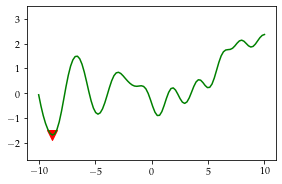

In [23]:
# plot the ground truth
#from fig_hp import *
fig, axes = plt.subplots(1, 1)
fig.set_size_inches(WIDTH, HEIGHT)

fig.subplots_adjust(left=.22, bottom=.20, right=.99, top=.97, hspace=0.5, wspace=0.4) 
   
ax = axes
ax.plot(np.squeeze(problem_config['parameter_set']), obj_vals_arr, color='g')
ax.scatter(problem_config['parameter_set'][f_min_id], f_min, 100, color='r', marker='v')
ax.set_ylim((f_min-1, max(f_max+1, 3.5)))

plt.savefig(f'./figs/run_config_{_}_ground_truth.png', format='png', bbox_inches='tight', dpi=500)

# run the following cell repeatedly to see the sampling process of the CONFIG algorithm

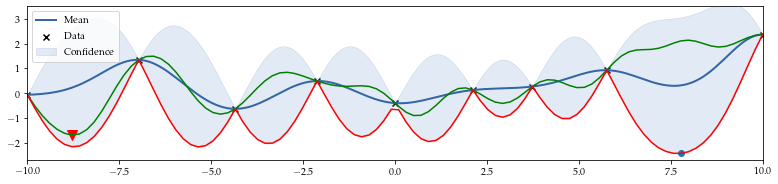

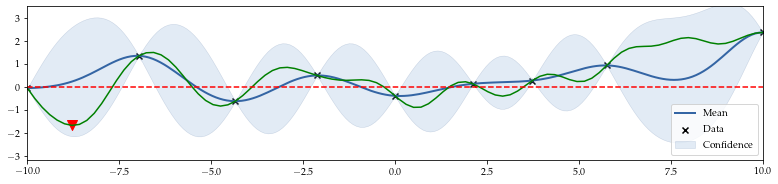

In [34]:
colors = ['red','purple', 'orange', 'green', 'blue', 'black', 'blue']
marksCur = ['o','s', '*', 'v', '^','+']
Run_steps = 20

if True:
#for _ in range(Run_steps):
    if True:
        y_obj, constr_vals = config_opt.make_step()
        config_opt_obj_list.append(y_obj[0, 0])
        config_opt_constr_list.append([constr_vals[0, k] for k in range(problem_config['num_constrs'])])
        
        cumu_pos_subopt_config.append(max(y_obj[0,0]-f_min,0))
        cumu_pos_vio_config.append(max(constr_vals[0,0],0))
        
    if True:
        
        
        #from fig_hp import *
        fig, axes = plt.subplots(1, 1)
        fig.set_size_inches(WIDTH*2.96, HEIGHT)

        fig.subplots_adjust(left=.22, bottom=.20, right=.99, top=.97, hspace=0.5, wspace=0.4) 
   
        ax = axes

        config_opt.gp_obj.plot(plot_limits=(-10, 10), ax=ax)
        ax.plot(np.squeeze(problem_config['parameter_set']), obj_vals_arr, color='g')
        ax.scatter(problem_config['parameter_set'][f_min_id], f_min, 100, color='r', marker='v')
     
        mean, std = config_opt.gp_obj.predict(problem_config['parameter_set'])
        lcb = mean+norm.ppf(2.5*0.01)*np.sqrt(std)
        ax.plot(np.squeeze(problem_config['parameter_set']), lcb , color='r')
        f_lcb_min = np.min(lcb)
        f_lcb_min_id = np.argmin(lcb)
        ax.scatter(problem_config['parameter_set'][f_lcb_min_id], f_lcb_min)
        ax.set_ylim((f_min-1, max(f_max+1, 3.5)))
        plt.savefig(f'./figs/run_config_with_lcb_{_}.png', format='png', bbox_inches='tight', dpi=500)
        
        
        fig, axes = plt.subplots(1, 1)
        fig.set_size_inches(WIDTH*2.96, HEIGHT)

        fig.subplots_adjust(left=.22, bottom=.20, right=.99, top=.97, hspace=0.5, wspace=0.4) 
   
        ax = axes

        config_opt.gp_obj.plot(plot_limits=(-10, 10), ax=ax)
        ax.plot(np.squeeze(problem_config['parameter_set']), obj_vals_arr, color='g')
        ax.plot(np.squeeze(problem_config['parameter_set']), np.zeros_like(np.squeeze(problem_config['parameter_set'])), 'r--')
        ax.scatter(problem_config['parameter_set'][f_min_id], f_min, 100, color='r', marker='v')
     
        ax.set_ylim((f_min-1.5, max(f_max+1, 3.5)))
        plt.savefig(f'./figs/run_config_without_lcb_{_}.png', format='png', bbox_inches='tight', dpi=500)

In [27]:
4.8/(WIDTH/HEIGHT)

2.966625463535229

In [18]:
# generate gif 
import imageio
images = []

for _ in range(Run_steps):
    file_name = f'./figs/compare_1d_{_}.png'
    images.append(imageio.imread(file_name))

imageio.mimsave('./figs/compare_1d.gif', images)



 /home/wenjie/miniconda3/lib/python3.8/site-packages/PIL/Image.py:3035: DecompressionBombWarning:Image size (115523630 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.


In [10]:
imageio.mimsave('./figs/compare_1d.gif', images)


# plot the constrained regret $\min_{t\in[T]}[f(x_t)-f^*]^++[g(x_t)]^+$
# When it converges to 0, the optimal solution is found.

In [109]:
def get_con_regret(obj_list, constr_list):
    obj_arr = np.array(obj_list)
    constr_arr = np.array(constr_list)
    pos_regret_arr = np.maximum(obj_arr-problem_config['f_min'],0)
    pos_constr_arr = np.maximum(constr_arr, 0)
    return np.minimum.accumulate(pos_regret_arr+np.sum(pos_constr_arr, axis=1))

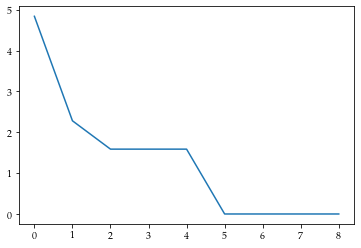

In [110]:
constr_regret = get_con_regret(config_opt_obj_list, config_opt_constr_list)
plt.plot(constr_regret)